In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam, Adagrad
import matplotlib.pyplot as plt


In [53]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
max_iters = 1_600_000#100_000
np.random.seed(10)


# normal models
def single_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
def multi_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
# inv gamma models
# mu_like = 3
# alpha_prior, beta_prior = 3, 1
# mean of the prior
# mu_prior = beta_prior / (alpha_prior - 1)
# # std of the prior
# sigma_prior = jnp.sqrt(beta_prior**2 / ((alpha_prior - 1)**2 * (alpha_prior - 2)))
# def single_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
# def multi_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
y_data = jnp.array([])

# compute true posteriors
true_mu_post = (sigma_like**2 * mu_prior + len(y_data) * sigma_prior**2 * jnp.mean(y_data)) / (len(y_data) * sigma_prior**2 + sigma_like**2)
true_sigma_post = jnp.sqrt((sigma_like**2 * sigma_prior**2) / (len(y_data) * sigma_prior**2 + sigma_like**2))


single_guide = AutoNormal(single_model)
multi_guide = AutoNormal(multi_model)

adam_step = 1e-2 # default 1e-2 "default" bc used often in examples, default eps = 1e-8
optimizer = Adam(adam_step, eps=1e-8)
single_elbo = Trace_ELBO()
multi_elbo = Trace_ELBO(num_particles=1000)

single_svi = SVI(single_model, single_guide, optimizer, loss=single_elbo)
multi_svi = SVI(multi_model, multi_guide, optimizer, loss=multi_elbo)


def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['mu_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['mu_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

single_elbo, single_tracker = run_svi(jax.random.PRNGKey(0), y_data, single_svi)
multi_elbo, multi_tracker = run_svi(jax.random.PRNGKey(10), y_data, multi_svi)

/Users/madelynandersen/miniconda3/envs/tfp_2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


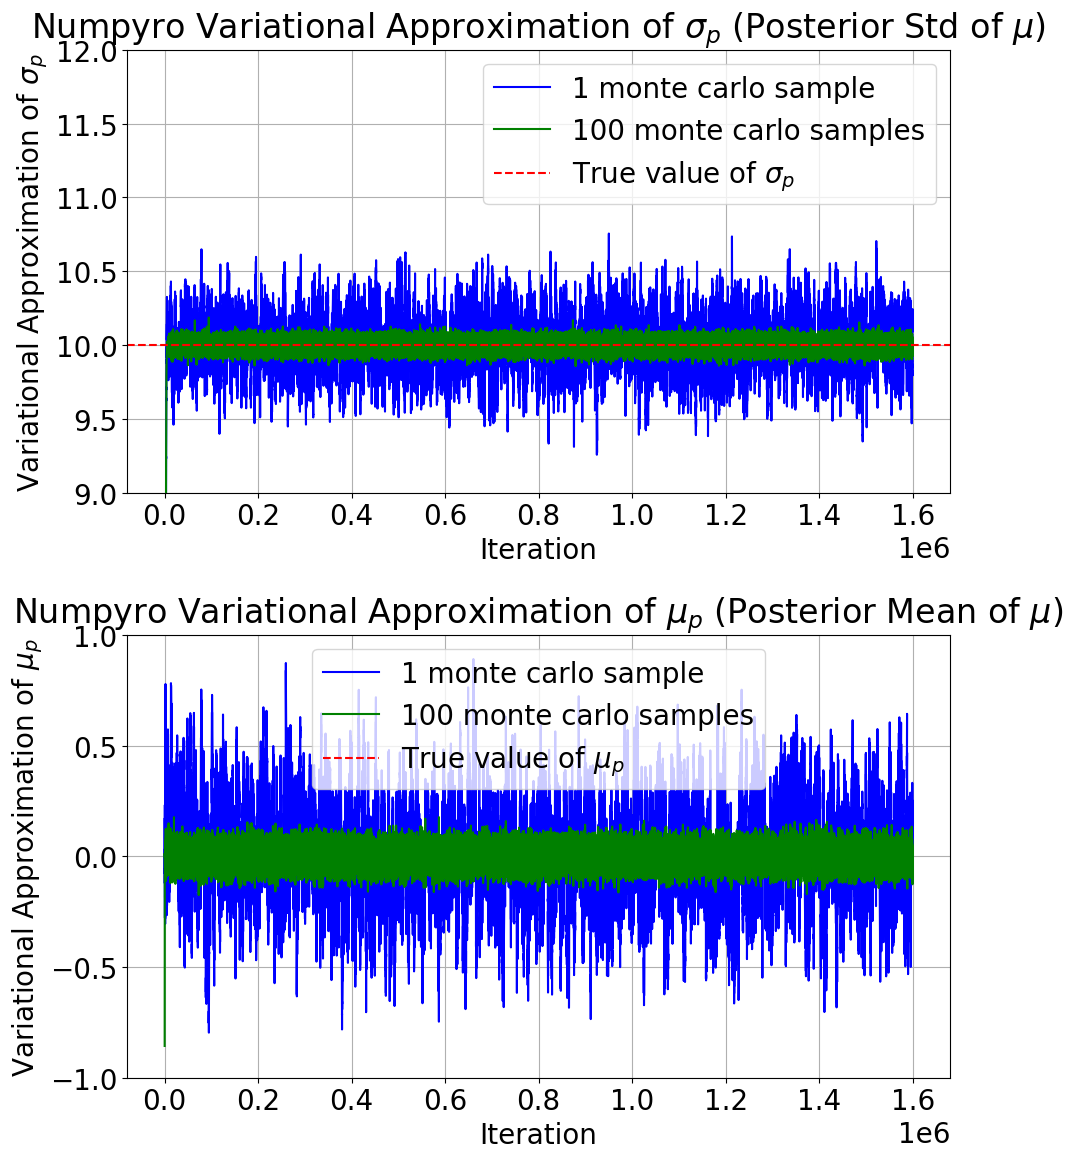

In [55]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 20
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_tracker['mu_loc'], label='1 monte carlo sample', color='blue')
axs[1].plot(multi_tracker['mu_loc'], label='100 monte carlo samples', color='green')
# axs[0].plot(second_tracker['mu_loc'], label='100 monte carlo samples, different optimizer', color='orange')
axs[1].axhline(true_mu_post, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'Numpyro Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend()
axs[1].grid()

axs[0].plot(single_tracker['std_loc'], label='1 monte carlo sample', color='blue')
axs[0].plot(multi_tracker['std_loc'], label='100 monte carlo samples', color='green')
axs[0].axhline(true_sigma_post, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'Numpyro Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.show()

# Appendix

First look at 10 runs with different seeds using the tfp defaults

In [ ]:
def make_model():
    def model(y):
        mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
        numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
    return model

# def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['mu_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['mu_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

model_0_1 = make_model()
model_0_100 = make_model()
model_1_1 = make_model()
model_1_100 = make_model()
model_2_1 = make_model()
model_2_100 = make_model()
model_3_1 = make_model()
model_3_100 = make_model()
model_4_1 = make_model()
model_4_100 = make_model()
model_5_1 = make_model()
model_5_100 = make_model()
model_6_1 = make_model()
model_6_100 = make_model()
model_7_1 = make_model()
model_7_100 = make_model()
model_8_1 = make_model()
model_8_100 = make_model()
model_9_1 = make_model()
model_9_100 = make_model()

guide_0_1 = AutoNormal(model_0_1)
guide_0_100 = AutoNormal(model_0_100)
guide_1_1 = AutoNormal(model_1_1)
guide_1_100 = AutoNormal(model_1_100)
guide_2_1 = AutoNormal(model_2_1)
guide_2_100 = AutoNormal(model_2_100)
guide_3_1 = AutoNormal(model_3_1)
guide_3_100 = AutoNormal(model_3_100)
guide_4_1 = AutoNormal(model_4_1)
guide_4_100 = AutoNormal(model_4_100)
guide_5_1 = AutoNormal(model_5_1)
guide_5_100 = AutoNormal(model_5_100)
guide_6_1 = AutoNormal(model_6_1)
guide_6_100 = AutoNormal(model_6_100)
guide_7_1 = AutoNormal(model_7_1)
guide_7_100 = AutoNormal(model_7_100)
guide_8_1 = AutoNormal(model_8_1)
guide_8_100 = AutoNormal(model_8_100)
guide_9_1 = AutoNormal(model_9_1)
guide_9_100 = AutoNormal(model_9_100)

tfp_default_optimizer = Adam(1e-3, eps=1e-7)
numpyro_default_optimizer = Adam(1e-2, eps=1e-8)

single_elbo = Trace_ELBO()
multi_elbo = Trace_ELBO(num_particles=100)

svi_0_1 = SVI(model_0_1, guide_0_1, tfp_default_optimizer, loss=single_elbo)
svi_0_100 = SVI(model_0_100, guide_0_100, tfp_default_optimizer, loss=multi_elbo)
svi_1_1 = SVI(model_1_1, guide_1_1, tfp_default_optimizer, loss=single_elbo)
svi_1_100 = SVI(model_1_100, guide_1_100, tfp_default_optimizer, loss=multi_elbo)
svi_2_1 = SVI(model_2_1, guide_2_1, tfp_default_optimizer, loss=single_elbo)
svi_2_100 = SVI(model_2_100, guide_2_100, tfp_default_optimizer, loss=multi_elbo)
svi_3_1 = SVI(model_3_1, guide_3_1, tfp_default_optimizer, loss=single_elbo)
svi_3_100 = SVI(model_3_100, guide_3_100, tfp_default_optimizer, loss=multi_elbo)
svi_4_1 = SVI(model_4_1, guide_4_1, tfp_default_optimizer, loss=single_elbo)
svi_4_100 = SVI(model_4_100, guide_4_100, tfp_default_optimizer, loss=multi_elbo)
svi_5_1 = SVI(model_5_1, guide_5_1, tfp_default_optimizer, loss=single_elbo)
svi_5_100 = SVI(model_5_100, guide_5_100, tfp_default_optimizer, loss=multi_elbo)
svi_6_1 = SVI(model_6_1, guide_6_1, tfp_default_optimizer, loss=single_elbo)
svi_6_100 = SVI(model_6_100, guide_6_100, tfp_default_optimizer, loss=multi_elbo)
svi_7_1 = SVI(model_7_1, guide_7_1, tfp_default_optimizer, loss=single_elbo)
svi_7_100 = SVI(model_7_100, guide_7_100, tfp_default_optimizer, loss=multi_elbo)
svi_8_1 = SVI(model_8_1, guide_8_1, tfp_default_optimizer, loss=single_elbo)
svi_8_100 = SVI(model_8_100, guide_8_100, tfp_default_optimizer, loss=multi_elbo)
svi_9_1 = SVI(model_9_1, guide_9_1, tfp_default_optimizer, loss=single_elbo)
svi_9_100 = SVI(model_9_100, guide_9_100, tfp_default_optimizer, loss=multi_elbo)

elbo_0_1, tracker_0_1 = run_svi(jax.random.PRNGKey(0), y_data, svi_0_1)
elbo_0_100, tracker_0_100 = run_svi(jax.random.PRNGKey(0), y_data, svi_0_100)
elbo_1_1, tracker_1_1 = run_svi(jax.random.PRNGKey(1), y_data, svi_1_1)
elbo_1_100, tracker_1_100 = run_svi(jax.random.PRNGKey(1), y_data, svi_1_100)
elbo_2_1, tracker_2_1 = run_svi(jax.random.PRNGKey(2), y_data, svi_2_1)
elbo_2_100, tracker_2_100 = run_svi(jax.random.PRNGKey(2), y_data, svi_2_100)
elbo_3_1, tracker_3_1 = run_svi(jax.random.PRNGKey(3), y_data, svi_3_1)
elbo_3_100, tracker_3_100 = run_svi(jax.random.PRNGKey(3), y_data, svi_3_100)
elbo_4_1, tracker_4_1 = run_svi(jax.random.PRNGKey(4), y_data, svi_4_1)
elbo_4_100, tracker_4_100 = run_svi(jax.random.PRNGKey(4), y_data, svi_4_100)
elbo_5_1, tracker_5_1 = run_svi(jax.random.PRNGKey(5), y_data, svi_5_1)
elbo_5_100, tracker_5_100 = run_svi(jax.random.PRNGKey(5), y_data, svi_5_100)
elbo_6_1, tracker_6_1 = run_svi(jax.random.PRNGKey(6), y_data, svi_6_1)
elbo_6_100, tracker_6_100 = run_svi(jax.random.PRNGKey(6), y_data, svi_6_100)
elbo_7_1, tracker_7_1 = run_svi(jax.random.PRNGKey(7), y_data, svi_7_1)
elbo_7_100, tracker_7_100 = run_svi(jax.random.PRNGKey(7), y_data, svi_7_100)
elbo_8_1, tracker_8_1 = run_svi(jax.random.PRNGKey(8), y_data, svi_8_1)
elbo_8_100, tracker_8_100 = run_svi(jax.random.PRNGKey(8), y_data, svi_8_100)
elbo_9_1, tracker_9_1 = run_svi(jax.random.PRNGKey(9), y_data, svi_9_1)
elbo_9_100, tracker_9_100 = run_svi(jax.random.PRNGKey(9), y_data, svi_9_100)

In [32]:
# plot the tfp default numpyro runs
single_runs_means = np.array([
    tracker_0_1['mu_loc'],
    tracker_1_1['mu_loc'],
    tracker_2_1['mu_loc'],
    tracker_3_1['mu_loc'],
    tracker_4_1['mu_loc'],
    tracker_5_1['mu_loc'],
    tracker_6_1['mu_loc'],
    tracker_7_1['mu_loc'],
    tracker_8_1['mu_loc'],
    tracker_9_1['mu_loc']
])
mean_single_means = np.mean(single_runs_means, axis=0)
std_single_means = np.std(single_runs_means, axis=0)

multi_runs_means = np.array([
    tracker_0_100['mu_loc'],
    tracker_1_100['mu_loc'],
    tracker_2_100['mu_loc'],
    tracker_3_100['mu_loc'],
    tracker_4_100['mu_loc'],
    tracker_5_100['mu_loc'],
    tracker_6_100['mu_loc'],
    tracker_7_100['mu_loc'],
    tracker_8_100['mu_loc'],
    tracker_9_100['mu_loc']
])
mean_multi_means = np.mean(multi_runs_means, axis=0)
std_multi_means = np.std(multi_runs_means, axis=0)

single_runs_stds = np.array([
    tracker_0_1['std_loc'],
    tracker_1_1['std_loc'],
    tracker_2_1['std_loc'],
    tracker_3_1['std_loc'],
    tracker_4_1['std_loc'],
    tracker_5_1['std_loc'],
    tracker_6_1['std_loc'],
    tracker_7_1['std_loc'], 
    tracker_8_1['std_loc'],
    tracker_9_1['std_loc']
])
mean_single_stds = np.mean(single_runs_stds, axis=0)
std_single_stds = np.std(single_runs_stds, axis=0)

multi_runs_stds = np.array([
    tracker_0_100['std_loc'],
    tracker_1_100['std_loc'],
    tracker_2_100['std_loc'],
    tracker_3_100['std_loc'],
    tracker_4_100['std_loc'],
    tracker_5_100['std_loc'],
    tracker_6_100['std_loc'],
    tracker_7_100['std_loc'],
    tracker_8_100['std_loc'],
    tracker_9_100['std_loc']
])
mean_multi_stds = np.mean(multi_runs_stds, axis=0)
std_multi_stds = np.std(multi_runs_stds, axis=0)

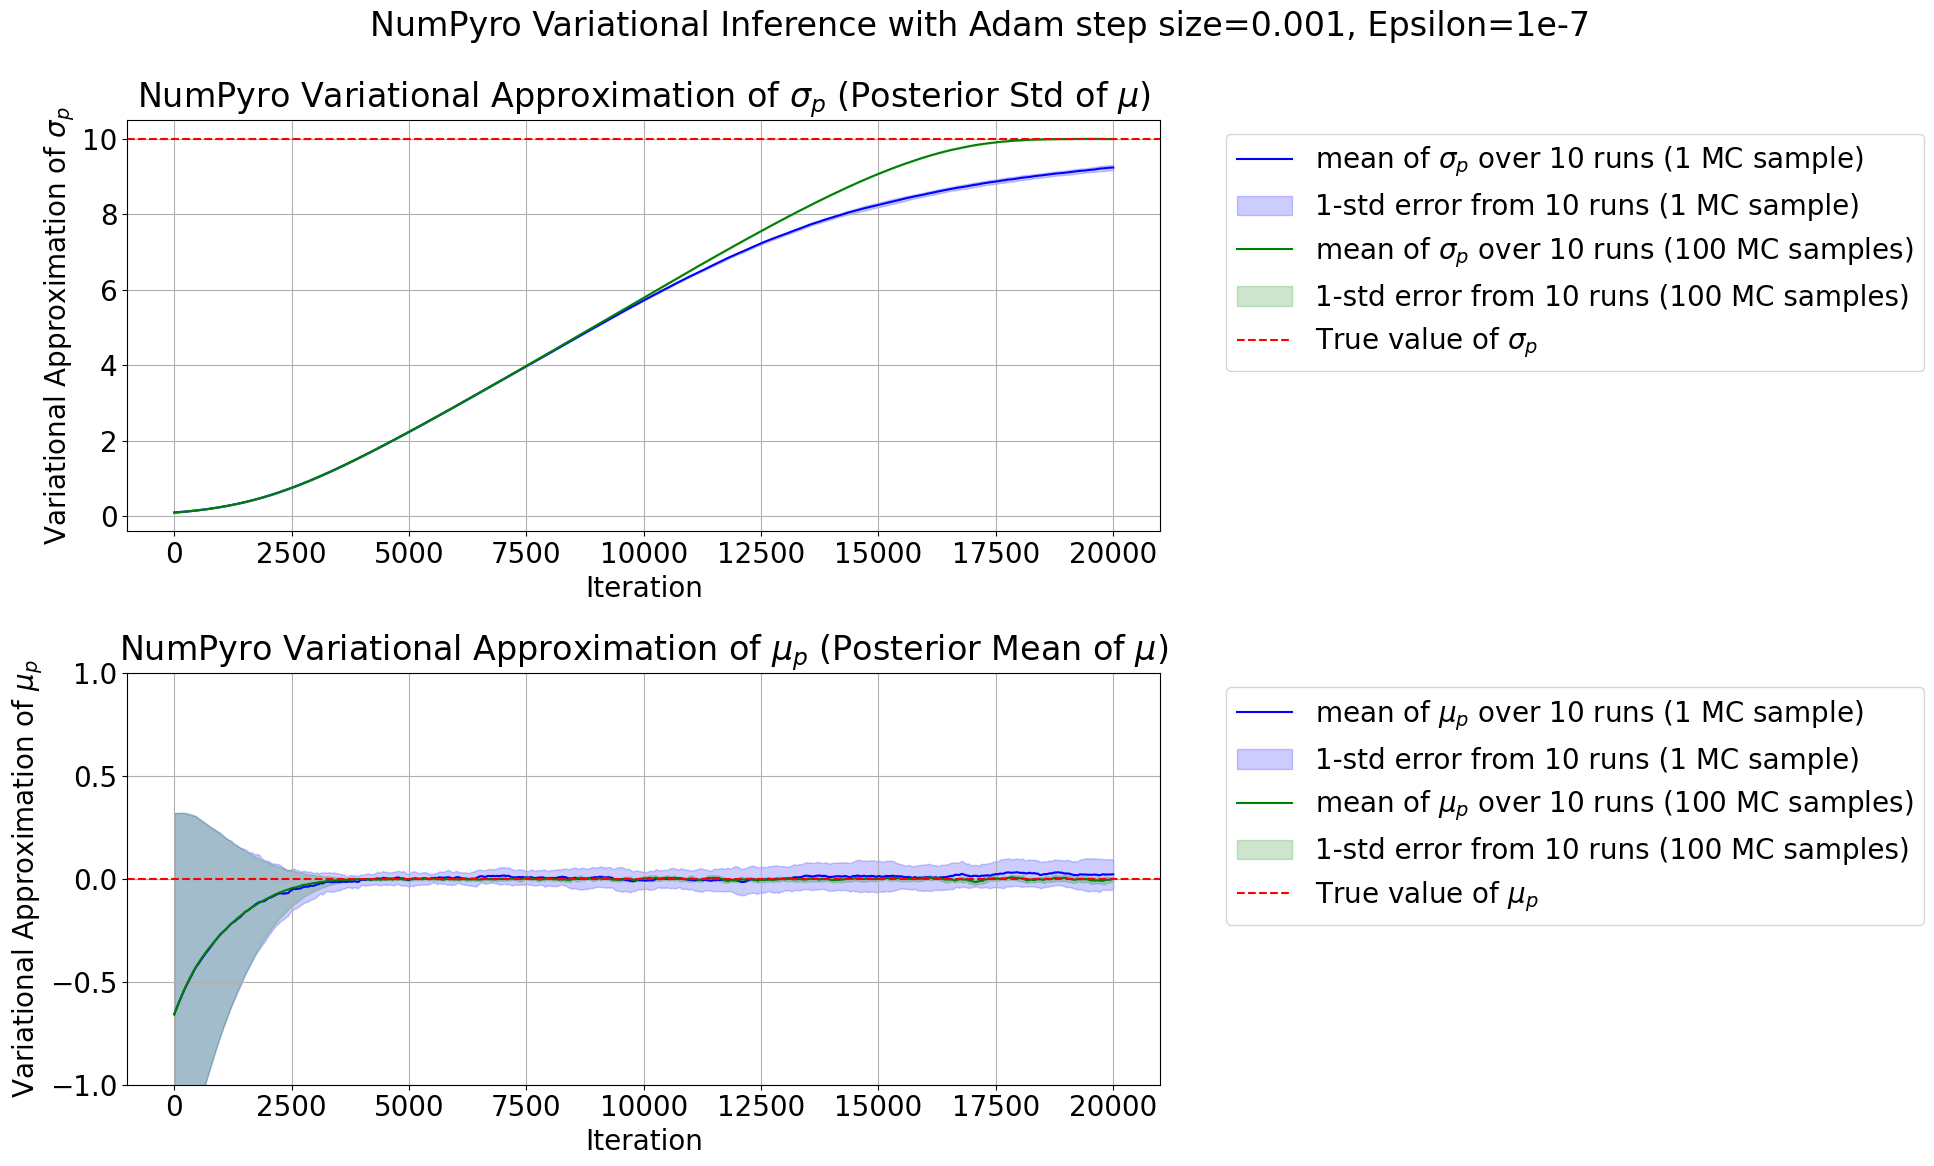

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})
# plot a summary of all 10 single sample runs as one line with error bars
axs[1].plot(
    mean_single_means,
    label=r'mean of $\mu_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_single_means)),
    mean_single_means - std_single_means,
    mean_single_means + std_single_means,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[1].plot(
    mean_multi_means,
    label=r'mean of $\mu_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_multi_means)),
    mean_multi_means - std_multi_means,
    mean_multi_means + std_multi_means,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[1].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'NumPyro Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()

axs[0].plot(
    mean_single_stds,
    label=r'mean of $\sigma_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_single_stds)),
    mean_single_stds - std_single_stds,
    mean_single_stds + std_single_stds,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[0].plot(
    mean_multi_stds,
    label=r'mean of $\sigma_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_multi_stds)),
    mean_multi_stds - std_multi_stds,
    mean_multi_stds + std_multi_stds,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[0].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'NumPyro Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
# legend to right outside
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()
# axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.suptitle('NumPyro Variational Inference with Adam step size=0.001, Epsilon=1e-7', fontsize=24)

plt.tight_layout()
plt.show()

Now let's do the numpyro default runs

In [31]:

model_0_1_n = make_model()
model_0_100_n = make_model()
model_1_1_n = make_model()
model_1_100_n = make_model()
model_2_1_n = make_model()
model_2_100_n = make_model()
model_3_1_n = make_model()
model_3_100_n = make_model()
model_4_1_n = make_model()
model_4_100_n = make_model()
model_5_1_n = make_model()
model_5_100_n = make_model()
model_6_1_n = make_model()
model_6_100_n = make_model()
model_7_1_n = make_model()
model_7_100_n = make_model()
model_8_1_n = make_model()
model_8_100_n = make_model()
model_9_1_n = make_model()
model_9_100_n = make_model()

guide_0_1_n = AutoNormal(model_0_1_n)
guide_0_100_n = AutoNormal(model_0_100_n)
guide_1_1_n = AutoNormal(model_1_1_n)
guide_1_100_n = AutoNormal(model_1_100_n)
guide_2_1_n = AutoNormal(model_2_1_n)
guide_2_100_n = AutoNormal(model_2_100_n)
guide_3_1_n = AutoNormal(model_3_1_n)
guide_3_100_n = AutoNormal(model_3_100_n)
guide_4_1_n = AutoNormal(model_4_1_n)
guide_4_100_n = AutoNormal(model_4_100_n)
guide_5_1_n = AutoNormal(model_5_1_n)
guide_5_100_n = AutoNormal(model_5_100_n)
guide_6_1_n = AutoNormal(model_6_1_n)
guide_6_100_n = AutoNormal(model_6_100_n)
guide_7_1_n = AutoNormal(model_7_1_n)
guide_7_100_n = AutoNormal(model_7_100_n)
guide_8_1_n = AutoNormal(model_8_1_n)
guide_8_100_n = AutoNormal(model_8_100_n)
guide_9_1_n = AutoNormal(model_9_1_n)
guide_9_100_n = AutoNormal(model_9_100_n)

numpyro_default_optimizer = Adam(1e-2, eps=1e-8)

svi_0_1_n = SVI(model_0_1_n, guide_0_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_0_100_n = SVI(model_0_100_n, guide_0_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_1_1_n = SVI(model_1_1_n, guide_1_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_1_100_n = SVI(model_1_100_n, guide_1_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_2_1_n = SVI(model_2_1_n, guide_2_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_2_100_n = SVI(model_2_100_n, guide_2_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_3_1_n = SVI(model_3_1_n, guide_3_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_3_100_n = SVI(model_3_100_n, guide_3_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_4_1_n = SVI(model_4_1_n, guide_4_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_4_100_n = SVI(model_4_100_n, guide_4_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_5_1_n = SVI(model_5_1_n, guide_5_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_5_100_n = SVI(model_5_100_n, guide_5_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_6_1_n = SVI(model_6_1_n, guide_6_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_6_100_n = SVI(model_6_100_n, guide_6_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_7_1_n = SVI(model_7_1_n, guide_7_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_7_100_n = SVI(model_7_100_n, guide_7_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_8_1_n = SVI(model_8_1_n, guide_8_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_8_100_n = SVI(model_8_100_n, guide_8_100_n, numpyro_default_optimizer, loss=multi_elbo)
svi_9_1_n = SVI(model_9_1_n, guide_9_1_n, numpyro_default_optimizer, loss=single_elbo)
svi_9_100_n = SVI(model_9_100_n, guide_9_100_n, numpyro_default_optimizer, loss=multi_elbo)
elbo_0_1_n, tracker_0_1_n = run_svi(jax.random.PRNGKey(0), y_data, svi_0_1_n)
elbo_0_100_n, tracker_0_100_n = run_svi(jax.random.PRNGKey(0), y_data, svi_0_100_n)
elbo_1_1_n, tracker_1_1_n = run_svi(jax.random.PRNGKey(1), y_data, svi_1_1_n)
elbo_1_100_n, tracker_1_100_n = run_svi(jax.random.PRNGKey(1), y_data, svi_1_100_n)
elbo_2_1_n, tracker_2_1_n = run_svi(jax.random.PRNGKey(2), y_data, svi_2_1_n)
elbo_2_100_n, tracker_2_100_n = run_svi(jax.random.PRNGKey(2), y_data, svi_2_100_n)
elbo_3_1_n, tracker_3_1_n = run_svi(jax.random.PRNGKey(3), y_data, svi_3_1_n)
elbo_3_100_n, tracker_3_100_n = run_svi(jax.random.PRNGKey(3), y_data, svi_3_100_n)
elbo_4_1_n, tracker_4_1_n = run_svi(jax.random.PRNGKey(4), y_data, svi_4_1_n)
elbo_4_100_n, tracker_4_100_n = run_svi(jax.random.PRNGKey(4), y_data, svi_4_100_n)
elbo_5_1_n, tracker_5_1_n = run_svi(jax.random.PRNGKey(5), y_data, svi_5_1_n)
elbo_5_100_n, tracker_5_100_n = run_svi(jax.random.PRNGKey(5), y_data, svi_5_100_n)
elbo_6_1_n, tracker_6_1_n = run_svi(jax.random.PRNGKey(6), y_data, svi_6_1_n)
elbo_6_100_n, tracker_6_100_n = run_svi(jax.random.PRNGKey(6), y_data, svi_6_100_n)
elbo_7_1_n, tracker_7_1_n = run_svi(jax.random.PRNGKey(7), y_data, svi_7_1_n)
elbo_7_100_n, tracker_7_100_n = run_svi(jax.random.PRNGKey(7), y_data, svi_7_100_n)
elbo_8_1_n, tracker_8_1_n = run_svi(jax.random.PRNGKey(8), y_data, svi_8_1_n)
elbo_8_100_n, tracker_8_100_n = run_svi(jax.random.PRNGKey(8), y_data, svi_8_100_n)
elbo_9_1_n, tracker_9_1_n = run_svi(jax.random.PRNGKey(9), y_data, svi_9_1_n)
elbo_9_100_n, tracker_9_100_n = run_svi(jax.random.PRNGKey(9), y_data, svi_9_100_n)

In [34]:
single_runs_means_n = np.array([
    tracker_0_1_n['mu_loc'],
    tracker_1_1_n['mu_loc'],
    tracker_2_1_n['mu_loc'],
    tracker_3_1_n['mu_loc'],
    tracker_4_1_n['mu_loc'],
    tracker_5_1_n['mu_loc'],
    tracker_6_1_n['mu_loc'],
    tracker_7_1_n['mu_loc'],
    tracker_8_1_n['mu_loc'],
    tracker_9_1_n['mu_loc']
])
mean_single_means_n = np.mean(single_runs_means_n, axis=0)
std_single_means_n = np.std(single_runs_means_n, axis=0)

multi_runs_means_n = np.array([
    tracker_0_100_n['mu_loc'],
    tracker_1_100_n['mu_loc'],
    tracker_2_100_n['mu_loc'],
    tracker_3_100_n['mu_loc'],
    tracker_4_100_n['mu_loc'],
    tracker_5_100_n['mu_loc'],
    tracker_6_100_n['mu_loc'],
    tracker_7_100_n['mu_loc'],
    tracker_8_100_n['mu_loc'],
    tracker_9_100_n['mu_loc']
])
mean_multi_means_n = np.mean(multi_runs_means_n, axis=0)
std_multi_means_n = np.std(multi_runs_means_n, axis=0)

single_runs_stds_n = np.array([
    tracker_0_1_n['std_loc'],
    tracker_1_1_n['std_loc'],
    tracker_2_1_n['std_loc'],
    tracker_3_1_n['std_loc'],
    tracker_4_1_n['std_loc'],
    tracker_5_1_n['std_loc'],
    tracker_6_1_n['std_loc'],
    tracker_7_1_n['std_loc'], 
    tracker_8_1_n['std_loc'],
    tracker_9_1_n['std_loc']
])
mean_single_stds_n = np.mean(single_runs_stds_n, axis=0)
std_single_stds_n = np.std(single_runs_stds_n, axis=0)

multi_runs_stds_n = np.array([
    tracker_0_100_n['std_loc'],
    tracker_1_100_n['std_loc'],
    tracker_2_100_n['std_loc'],
    tracker_3_100_n['std_loc'],
    tracker_4_100_n['std_loc'],
    tracker_5_100_n['std_loc'],
    tracker_6_100_n['std_loc'],
    tracker_7_100_n['std_loc'],
    tracker_8_100_n['std_loc'],
    tracker_9_100_n['std_loc']
])
mean_multi_stds_n = np.mean(multi_runs_stds_n, axis=0)
std_multi_stds_n = np.std(multi_runs_stds_n, axis=0)

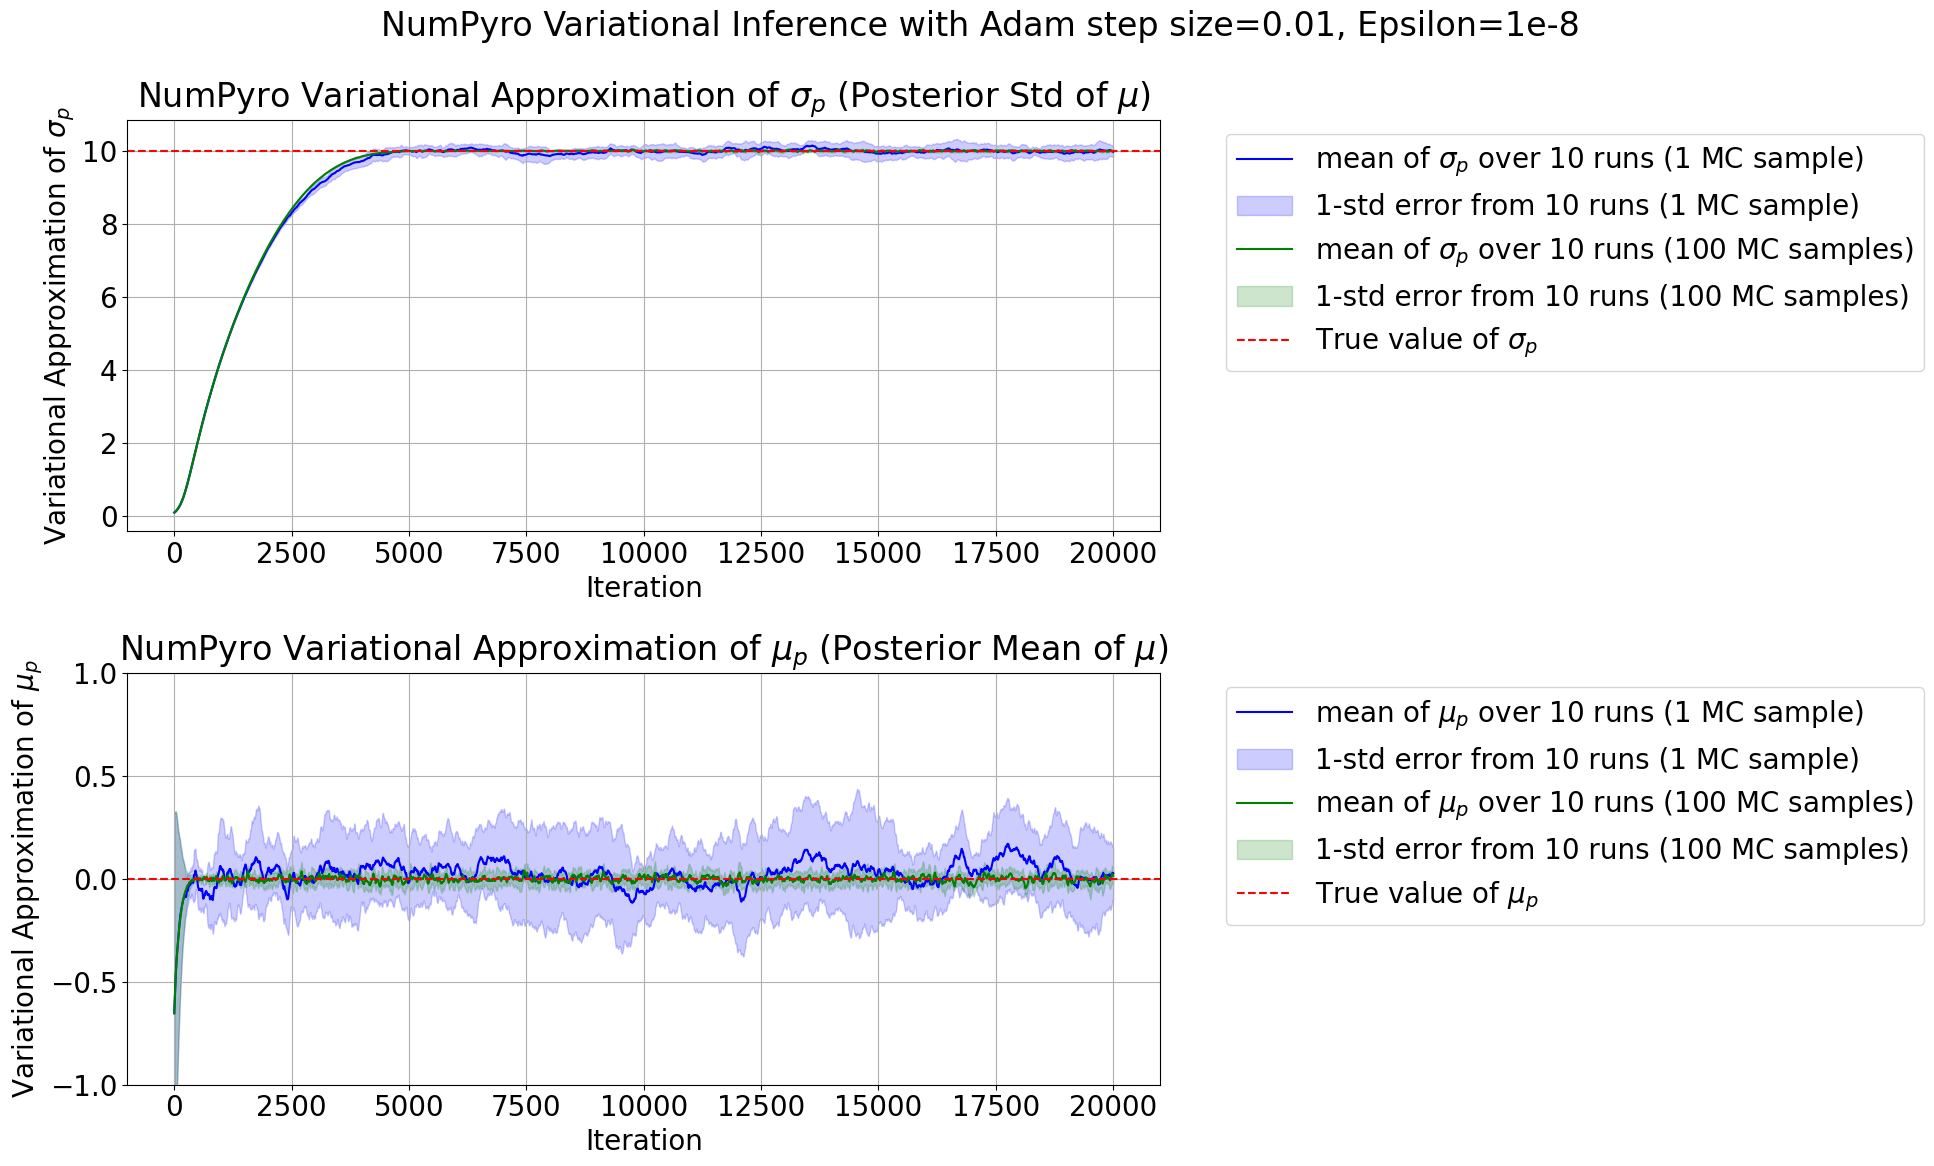

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})
# plot a summary of all 10 single sample runs as one line with error bars
axs[1].plot(
    mean_single_means_n,
    label=r'mean of $\mu_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_single_means_n)),
    mean_single_means_n - std_single_means_n,
    mean_single_means_n + std_single_means_n,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[1].plot(
    mean_multi_means_n,
    label=r'mean of $\mu_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[1].fill_between(
    np.arange(len(mean_multi_means_n)),
    mean_multi_means_n - std_multi_means_n,
    mean_multi_means_n + std_multi_means_n,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[1].axhline(mu_prior, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'NumPyro Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()

axs[0].plot(
    mean_single_stds_n,
    label=r'mean of $\sigma_p$ over 10 runs (1 MC sample)',
    color='blue'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_single_stds_n)),
    mean_single_stds_n - std_single_stds_n,
    mean_single_stds_n + std_single_stds_n,
    color='blue',
    alpha=0.2,
    label='1-std error from 10 runs (1 MC sample)'
)
# plot a summary of all 10 multi sample runs as one line with error bars
axs[0].plot(
    mean_multi_stds_n,
    label=r'mean of $\sigma_p$ over 10 runs (100 MC samples)',
    color='green'
)
# plot the error bar
axs[0].fill_between(
    np.arange(len(mean_multi_stds_n)),
    mean_multi_stds_n - std_multi_stds_n,
    mean_multi_stds_n + std_multi_stds_n,
    color='green',
    alpha=0.2,
    label='1-std error from 10 runs (100 MC samples)'
)
axs[0].axhline(sigma_prior, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'NumPyro Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
# legend to right outside
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()
# axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)

plt.suptitle('NumPyro Variational Inference with Adam step size=0.01, Epsilon=1e-8', fontsize=24)

plt.tight_layout()
plt.show()

What if we run with Adagrad?

In [8]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
max_iters = 1_600_000#100_000
np.random.seed(10)


# normal models
def single_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
def multi_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
# inv gamma models
# mu_like = 3
# alpha_prior, beta_prior = 3, 1
# mean of the prior
# mu_prior = beta_prior / (alpha_prior - 1)
# # std of the prior
# sigma_prior = jnp.sqrt(beta_prior**2 / ((alpha_prior - 1)**2 * (alpha_prior - 2)))
# def single_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
# def multi_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
y_data = jnp.array([])

# compute true posteriors
true_mu_post = (sigma_like**2 * mu_prior + len(y_data) * sigma_prior**2 * jnp.mean(y_data)) / (len(y_data) * sigma_prior**2 + sigma_like**2)
true_sigma_post = jnp.sqrt((sigma_like**2 * sigma_prior**2) / (len(y_data) * sigma_prior**2 + sigma_like**2))


single_guide = AutoNormal(single_model)
multi_guide = AutoNormal(multi_model)

adam_step = 5e-1 # default 1e-2 "default" bc used often in examples, default eps = 1e-8
optimizer = Adagrad(step_size=1.0) # momentum??, default from pymc uses epsilon=1e-06)
single_elbo = Trace_ELBO()
multi_elbo = Trace_ELBO(num_particles=1000)

single_svi = SVI(single_model, single_guide, optimizer, loss=single_elbo)
multi_svi = SVI(multi_model, multi_guide, optimizer, loss=multi_elbo)


def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['mu_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['mu_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

single_elbo, single_tracker = run_svi(jax.random.PRNGKey(0), y_data, single_svi)
multi_elbo, multi_tracker = run_svi(jax.random.PRNGKey(10), y_data, multi_svi)

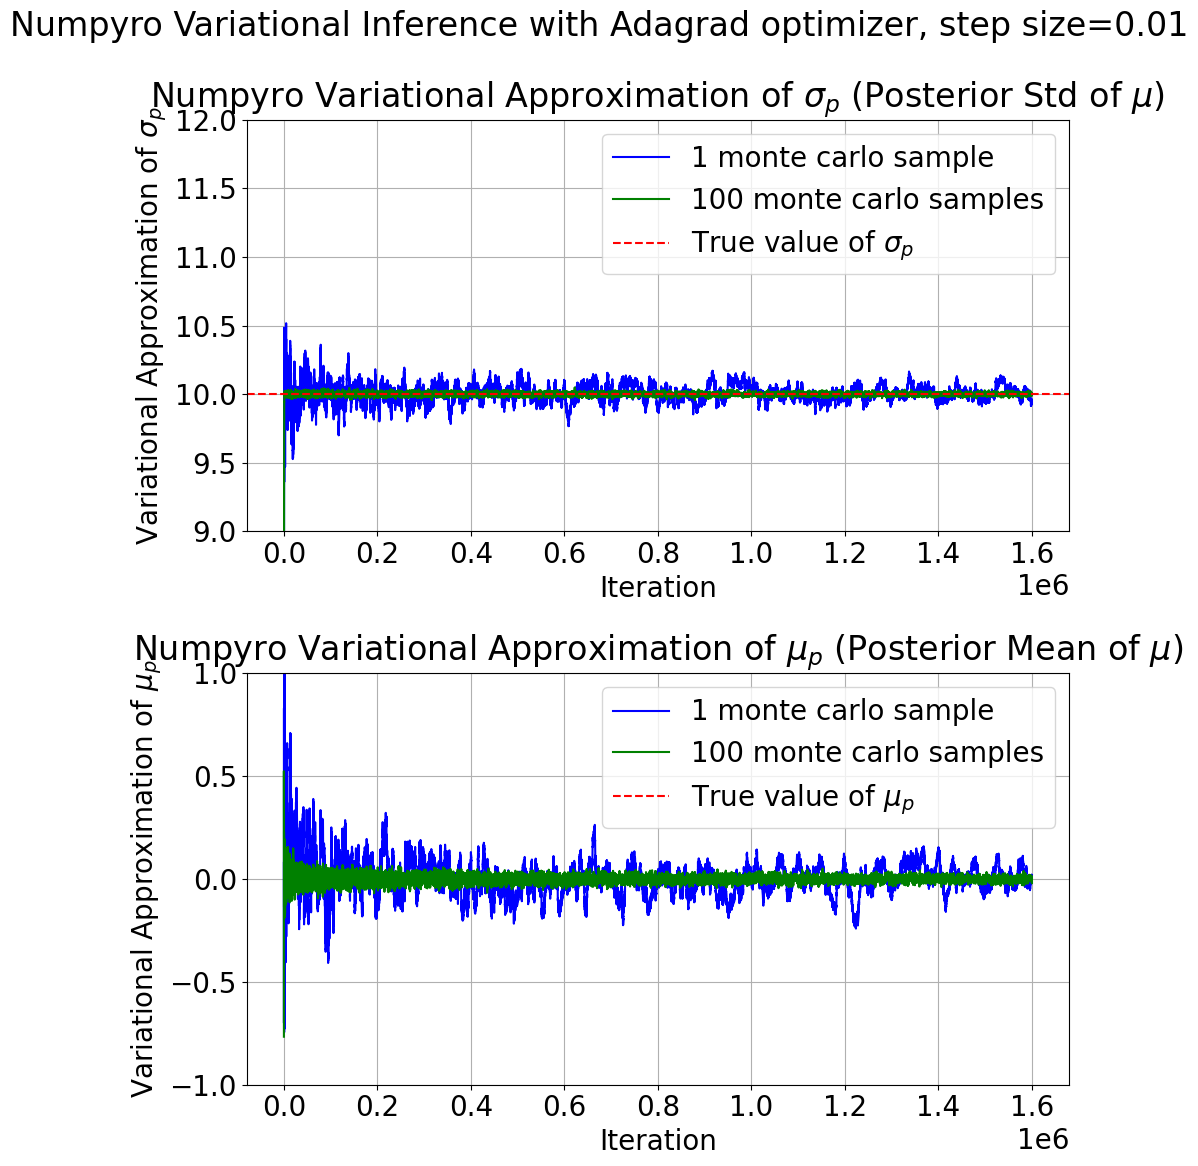

In [9]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 20
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_tracker['mu_loc'], label='1 monte carlo sample', color='blue')
axs[1].plot(multi_tracker['mu_loc'], label='100 monte carlo samples', color='green')
# axs[0].plot(second_tracker['mu_loc'], label='100 monte carlo samples, different optimizer', color='orange')
axs[1].axhline(true_mu_post, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[1].set_title(r'Numpyro Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].legend()
axs[1].grid()

axs[0].plot(single_tracker['std_loc'], label='1 monte carlo sample', color='blue')
axs[0].plot(multi_tracker['std_loc'], label='100 monte carlo samples', color='green')
axs[0].axhline(true_sigma_post, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[0].set_title(r'Numpyro Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(sigma_prior - 1, sigma_prior + 2)
axs[1].set_ylim(mu_prior - 1, mu_prior + 1)
plt.suptitle('Numpyro Variational Inference with Adagrad optimizer, step size=0.01', fontsize=24)

plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.show()